In [1]:
#importing required modules
import numpy as np
import cv2
from numpy.random import permutation
from numpy.random import choice 
import matplotlib.pyplot as plt
import time

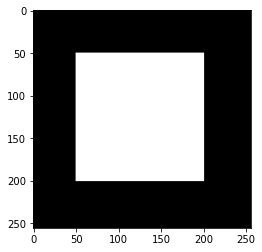

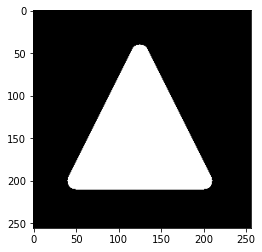

In [2]:
#creating triangle and square shape

#square shape
square = np.zeros((256, 256, 3), np.uint8)
cv2.rectangle(square, pt1=(50,50), pt2=(200,200), color=(255,255,255), thickness=-1)
plt.imshow(square)
plt.show()

#triangle shape
triangle = np.zeros((256, 256, 3), np.uint8)
vertices = np.array([[50, 200], [200, 200], [125, 50]], np.int32)
vertices = vertices.reshape((-1, 1, 2))
cv2.polylines(triangle, [vertices], isClosed=True, color=(255, 255, 255), thickness=20)
cv2.fillPoly(triangle, [vertices], color=(255, 255, 255))
plt.imshow(triangle)

## Q1: shape detection using  a bank of orientation-selective 2D Gabor filters.

### function releated to square detection

In [3]:
#function to check if the image is a square with edges oriented with angles as theta_pair
def square_detection_angle(filtered_images,theta_pair):
    
    #getting the minimum of each pixel value in both the filtered images ,for all pixels
    #bcz if there is intersection then the same pixel value in both the images will be high
    image_intersection=np.minimum(filtered_images[theta_pair[0]],filtered_images[theta_pair[1]])
    #getting unique values from the image intersection
    unique_values=np.unique(image_intersection)
    #sorting the values
    unique_values.sort()
    #if no of unique values is less than 2 i.e all the pixel values are same
    if len(unique_values)<2:
        #if all the pixel values are same , then it is not a square
        return False
    
    #binary thresholding the intersection image , with threshold value as the second highest pixel value
    threshold_value=int(unique_values[-2])
    _,threshold_image = cv2.threshold(np.minimum(filtered_images[theta_pair[0]],filtered_images[theta_pair[1]]),threshold_value,255,cv2.THRESH_BINARY)
    #getting value counts of each pixel value
    value_counts=np.unique(threshold_image,return_counts=True)
    #if the high pixel value count is 4 i.e there are 4 points of intersection
    if value_counts[1][-1]==4:
        #then it is a square
        return True
    #else it is not a square
    else:
        return False

In [4]:
#function that checks if image is a square with edges oriented with angles among theta_pairs
def square_detection_angles(filtered_images,square_theta_pairs):
    #for each perpendicular theta pair
    for theta_pair in square_theta_pairs:
        #checking if it is a square with edges oriented with angles as theta pair
        if square_detection_angle(filtered_images,theta_pair):
            #if yes , return true
            return True
    #if it is not a square for any of the theta pairs, then return false
    return False

In [5]:
#function to generate the filtered images
def square_filter_passing(filters,image):
    #to store filtered images
    filtered_images={}
    #to store angle
    angle=0
    #for each filter
    for filtr in filters:
        #getting the filtered image
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, filtr)
        #performing binary thresholding on the filtered image
        _,threshold_image = cv2.threshold(filtered_image,180,255,cv2.THRESH_BINARY)
        #adding the thresholded image to dict
        filtered_images[angle]=threshold_image
        #incrementing the angle 
        angle+=10
    #returning dict of filtered_images
    return filtered_images

In [6]:
#function to generate square filters when the theta list is passed
def square_filters_generation(theta_list):
    
    #to store the filters
    filters = []
    #initializing parameters for gabor kernel
    kernel_size = 5
    sigma = 2.0
    #for each diff orientation
    for theta in theta_list:
        #getting the gabor kernel with that orientation
        filtr = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd=4, gamma=2, psi=0,ktype=cv2.CV_32F)
        #appending it to the filters list
        filters.append(filtr)
    return filters

In [7]:
#function for square detection
def square_detection(image):
    #theta list contains angles 0,10,20,...170 
    theta=np.pi/18
    theta_list=[]
    for i in range(18):
        theta_list.append(i*theta)
        
    #getting filters with different orientations
    filters=square_filters_generation(theta_list)
    #getting the filtered images by passing the image through each filter
    filtered_images=square_filter_passing(filters,image)
    #getting all theta pairs that are perpendicular ex:(0,90),(10,110),.....,(80,170)
    square_theta_pairs=[]
    for i in range(0,90,80):
        square_theta_pairs.append([i,i+90])
    #if it a square with edges oriented with angles among theta_pairs
    if square_detection_angles(filtered_images,square_theta_pairs):
        #then return true
        return True
    
    #else return false
    else:
        return False

### functions related to triangle detection

In [8]:
#fucnction to generate triangle filters
def triangle_filters_generation(theta_list):
    #to store the filters
    filters = []
    #initializing parameters for gabor kernel
    kernel_size = 31
    sigma = 2.0
    #for each diff orientation
    for theta in theta_list:
        #getting the gabor kernel with that orientation
        filtr = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd=2, gamma=0.5, psi=0,ktype=cv2.CV_32F)
        #appending it to the filters list
        filters.append(filtr)
    return filters

In [9]:
#function to get the filtered images 
def triangle_filter_passing(filters,image):
    #to store filtered images
    filtered_images={}
    #to store angle
    angle=45
    #for each filter
    for filtr in filters:
        #getting the filtered image
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, filtr)
        #performing binary thresholding on the filtered image
        _,threshold_image = cv2.threshold(filtered_image,180,255,cv2.THRESH_BINARY)
        #adding the thresholded image to dict
        filtered_images[angle]=threshold_image
        #incrementing the angle 
        angle+=45
    #returning dict of filtered_images
    return filtered_images

In [10]:
#function to get the corners of triangle
def getting_corners(filtered_images):
    #getting right corner
    corner1 = 255*np.uint8(filtered_images[45]*filtered_images[90]) 
    #getting left corner
    corner2 = 255*np.uint8(filtered_images[90]*filtered_images[135]) 
    #getting top corner
    corner3 = 255*np.uint8(filtered_images[135]*filtered_images[90]) 
    #returning the corners
    return [corner1,corner2,corner3]

In [11]:
#function for triangle detection
def triangle_detection(image):
    
    #theta list contains angles 45,90,135
    theta_list=[1*np.pi/4,2*np.pi/4,3*np.pi/4]
    #getting filters with different orientations
    filters = triangle_filters_generation(theta_list)
    #getting the filtered images by passing the image through each filter
    filtered_images=triangle_filter_passing(filters,image)
    #getting corners of triangle
    corners=getting_corners(filtered_images)
    #for each corner
    for i in range(3):
        #getting the current corner
        corner = np.asarray(np.nonzero(corners[i]))
        #if any one of the corner is empty(all zeros) i.e no intersection point
        if corner.shape[1] == 0:
            return False
    #return true if all the three corners have non zero points i.e there are intersection points
    return True

### checking for generated shapes

In [12]:
#function for shape detection
def shape_detection(image):
    #converting rbg to greyscale by taking mean over rgb axis
    image_gs = np.uint8(np.mean(image, axis=2))
    #performing  adaptive thresholding on grey scale image
    _,threshold_image = cv2.threshold(image_gs,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #if the shape is a square
    if square_detection(threshold_image):
        #then return 0
        return int(0)
    #else if the shape is a triangle
    elif triangle_detection(threshold_image):
        #then return 1
        return int(1)
    #else return 2
    else:
        return int(2)

In [13]:
#checking if the shape detection is working or not on sample images

#checking for square shape
shp=shape_detection(square)
if shp==0:
    print('correct detection')
else:
    print('incorrect detection')

#checking for triangle shape
shp=shape_detection(triangle)
if shp==1:
    print('correct detection')
else:
    print('incorrect detection')

correct detection
correct detection


## Q2 :  visual search paradigm simulation

In [14]:
#converting triangle and square to grey scale , to be used in the paradigm
triangle=np.uint8(np.mean(triangle, axis=2))
square=np.uint8(np.mean(square, axis=2))

In [15]:
#function to simulate feature paradigm
def feature_paradigm(No_of_objects):
    #to store the paradigm
    shape=triangle.shape[0]*10
    paradigm = np.zeros((shape,shape,3), np.uint8)
    #for red and blue colors
    color = [0,2]
    
    #randomly select locations for object placement among 100 locations
    object_locations = permutation(np.arange(100))[:No_of_objects]
    #selecting the location for the placement of odd object
    odd_object_location = object_locations[-1]
    
    #randomly selecting the color of the odd object
    odd_object_color = int(color[int(choice(2,1))])
    #getting the color of the like objects
    like_object_color = int(2 - odd_object_color)

    #matrix for location k in among the 100 locations  in the image will be
    #img[(k/10)*triangle.shape[0]:(k/10+1)*triangle.shape[0], (k%10)*triangle.shape[0]:(k%10+1)*triangle.shape[0],:]
    
    #for each object location
    for object_loc in object_locations:
        
        shp=triangle.shape[0]
        #getting the row and column index of the location matrix
        ind1=int(object_loc/10)
        ind2=int(object_loc%10)
        
        #if the current object location is odd object location
        if object_loc == odd_object_location:
            # the odd object's color axis will be assigned triangle image
            paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, odd_object_color] = triangle
        #else
        else:
            #the like object's color axis will be assigned triangle image
            paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, like_object_color] = triangle

    return (paradigm,object_locations)

In [16]:
#function to simulate conjunction paradigm
def conjunction_paradigm(No_of_objects):
    #to store the paradigm
    shape=triangle.shape[0]*10
    paradigm = np.zeros((shape,shape,3), np.uint8)
    #for red and blue colors
    color = [0,2]
    
    #randomly dividing no of squares and no of triangle among no of objects
    No_of_squares = int(choice(No_of_objects-1,1)) + 1 
    No_of_triangles = No_of_objects - No_of_squares
    
    #randomly getting square and triangles locations
    object_locations = permutation(np.arange(100))[:No_of_objects] 
    square_locations = object_locations[:No_of_squares] 
    triangle_locations = object_locations[No_of_squares:]
    
    #randomly getting triangle and square colors 
    triangle_color = int(color[int(choice(2,1))])
    square_color = int(2 - triangle_color)
    
    #randomly chossing odd object location among object locations
    odd_object_location=object_locations[choice(No_of_objects,1)]
    
    #for each object location
    for object_loc in object_locations:
        #getting the row and columns index of the location matrix
        shp=triangle.shape[0]
        ind1=int(object_loc/10)
        ind2=int(object_loc%10)
        #if the current object location is square location
        if object_loc in square_locations:
            #if the current object location is odd object location
            if object_loc==odd_object_location:
                #then the square objects ,triangle color axis will be assigned square image
                paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, triangle_color] = square
            #if the current object is not odd object
            else:
                #then the square objects ,square color axis will be assigned square image
                paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, square_color] = square
        #if the current object location is triangle location
        else:
            #if the current object location is odd object location
            if object_loc==odd_object_location:
                #then the triangle objects,square color axis will be assigned triangle image
                paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, square_color] = triangle
            #if the current object is not odd object
            else:
                #then the triangle objects,triangle color axis will be assigned triangle image
                paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, triangle_color] = triangle
    return (paradigm,object_locations)

In [17]:
#function to generate paradigm
def generate_paradigm(No_of_objects, Experiment_type):
    #if the experiment type is feature paradigm
    if Experiment_type == 'feature':
        #then calling feature paradigm function
        paradigm,object_locations = feature_paradigm(No_of_objects)
    #else calling conjunction paradigm function
    else:
        paradigm,object_locations = conjunction_paradigm(No_of_objects)
    
    #returning paradigm
    return (np.uint8(paradigm),object_locations)

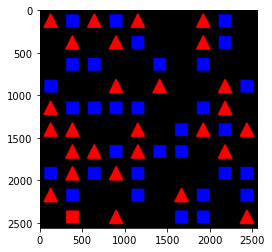

In [18]:
#displaying example paradigm
plt.imshow(generate_paradigm(60,1)[0])

## Q3 : implementation of feature integration theory

In [19]:
#functcion to perform feature search
def feature_search(color_map, shape_map):
    #this search is based on just one feature, counting the occurrences of each type i.e. 
    #no of blues and no of reds. The one which gives only 1 occurrence will be the odd one.
    
    #initializing counts
    red_count=0
    blue_count=0
    #counting no of red and blue shapes
    for color in color_map:
        if color==0:
            red_count+=1
        else:
            blue_count+=1

    #if red count is 1 then the odd shape is red color
    if red_count==1:
        return True
    #if blue count is 1 then the odd shape is blue color
    elif blue_count==1:
        return True
    
    time.sleep(0.02)
    
    return False

In [20]:
#functcion to perform feature search
def conjunction_search(color_map, shape_map):
    #initializing counts 
    #based on 2 features, so we get 4 counts
    blue_triangles_count = 0
    red_triangles_count = 0
    blue_squares_count = 0
    red_squares_count = 0
    
    for i in range(color_map.shape[0]):
        #if red color
        if (color_map[i] == 0): 
            #if square shape
            if (shape_map[i] == 0): 
                red_squares_count+=1
            else: 
                red_triangles_count+=1
        #if blue color
        else:
            #if square shape
            if (shape_map[i] == 0): 
                blue_squares_count+=1
            else: 
                blue_triangles_count+=1
                
        time.sleep(0.02)
    
    #if any one of them is 1 , then return true
    if blue_triangles_count== 1:
        return True
    elif red_triangles_count == 1:
        return True
    elif blue_squares_count == 1:
        return True
    elif red_squares_count == 1:
        return True
    
    time.sleep(0.02)
    
    #else return false
    return False

In [21]:
# function to detect the color of an image i.e  0 - red , 1 - blue 
def color_detection(image):
    #getting color intensities
    rgb_intensities = np.sum(image, axis=(0,1))
    #gettig the channel index of max intensity
    color_index = np.argmax(rgb_intensities) 
    #if the color_index is 0
    if color_index == 0:
        #then it is red
        return 0
    #else
    else:
        #it is blue, since in our paradigm we have only 2 colors
        return 1

In [22]:
#function to get the feature maps
def generate_feature_maps( paradigm , object_locations):
    # creating shape map i.e 0 - square , 1 - triangle 
    shape_map = np.zeros(object_locations.shape)
    #creating color map i.e 0 - red , 1 - blue 
    color_map = np.zeros(object_locations.shape)
    #for each object location
    ind=0
    for object_loc in object_locations:
        #getting the row and column index of the location matrix
        shp=triangle.shape[0]
        ind1=int(object_loc/10)
        ind2=int(object_loc%10)
        #getting objects image
        image = paradigm[ind1*shp:(ind1+1)*shp, ind2*shp:(ind2+1)*shp, :]
        #getting shape of curr object
        shape_map[ind] = shape_detection(image)
        #getting color of current object
        color_map[ind] = color_detection(image)
        ind+=1
    return (shape_map, color_map)


In [23]:
#to store feature search times
feature_search_times = []
#repeating for various no of objects
for No_of_objects in range(2,50):
    #generating feature paradigm
    paradigm,object_locations = generate_paradigm(No_of_objects, 'feature')
    #generating feature maps
    shape_map, color_map = generate_feature_maps(paradigm,object_locations)
    #to measure time
    ticks = time.time()
    found = feature_search(color_map, shape_map)
    feature_search_times.append(time.time() - ticks)

In [24]:
#to store conjunction search times
conjunction_search_times = []
#repeating for various no of objects
for No_of_objects in range(2,50):
    #generating conjunction paradigm
    paradigm,object_locations = generate_paradigm(No_of_objects, 'conjunction')
    #generating feature maps
    shape_map, color_map = generate_feature_maps( paradigm,object_locations)
    #to measure time
    ticks = time.time()
    found = conjunction_search(color_map, shape_map)
    conjunction_search_times.append(time.time() - ticks)


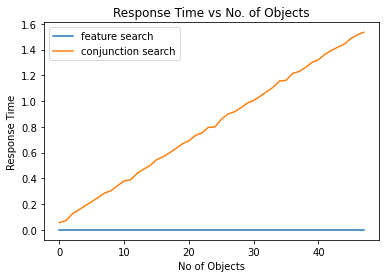

In [25]:
#plotting
plt.plot(feature_search_times, label='feature search')
plt.plot(conjunction_search_times, label='conjunction search')

plt.ylabel('Response Time')
plt.xlabel('No of Objects')
plt.title('Response Time vs No. of Objects')
plt.legend()